# Agent Chat with Multimodal Models: GPT-4V

### Before everything starts, install AutoGen with the `lmm` option
```bash
pip install "pyautogen[lmm]~=0.2.0b4"
```

In [1]:
import requests
import json
import os

from typing import Any, Callable, Dict, List, Optional, Tuple, Type, Union

import autogen
from autogen import AssistantAgent, Agent, UserProxyAgent, ConversableAgent
from termcolor import colored
import random

<a id="app-1"></a>
## Application 1: Image Chat

In this section, we present a straightforward dual-agent architecture to enable user to chat with a multimodal agent.


First, we show this image and ask a question.
![](https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0)

Within the user proxy agent, we can decide to activate the human input mode or not (for here, we use human_input_mode="NEVER" for conciseness). This allows you to interact with LMM in a multi-round dialogue, enabling you to provide feedback as the conversation unfolds.

In [2]:
from autogen.agentchat.contrib.multimodal_conversable_agent import MultimodalConversableAgent

config_list_4v = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4-vision-preview"],
    },
)


config_list_gpt4 = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4", "gpt-4-0314", "gpt4", "gpt-4-32k", "gpt-4-32k-0314", "gpt-4-32k-v0314"],
    },
)

gpt4_llm_config = {"config_list": config_list_gpt4, "cache_seed": 42}

In [3]:
image_agent = MultimodalConversableAgent(
    name="image-explainer",
    max_consecutive_auto_reply=10,
    llm_config={"config_list": config_list_4v, "temperature": 0.5, "max_tokens": 300}
)

user_proxy = autogen.UserProxyAgent(
    name="User_proxy",
    system_message="A human admin.",
    human_input_mode="NEVER", # Try between ALWAYS or NEVER
    max_consecutive_auto_reply=0
)

# Ask the question with an image
user_proxy.initiate_chat(image_agent, 
                         message="""What's the breed of this dog? 
<img https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0>.""")

User_proxy (to image-explainer):

What's the breed of this dog? 
<image>.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
image-explainer (to User_proxy):

The dog in the image appears to be a Goldendoodle, which is a crossbreed between a Golden Retriever and a Poodle. They are known for their curly, hypoallergenic coats, which can vary in color, and their friendly and affectionate nature.

--------------------------------------------------------------------------------


Now, input another image, and ask a followup question.

![](https://th.bing.com/th/id/OIP.29Mi2kJmcHHyQVGe_0NG7QHaEo?pid=ImgDet&rs=1)

In [4]:
# Ask the question with an image
user_proxy.send(message="""What is this breed? 
<img https://th.bing.com/th/id/OIP.29Mi2kJmcHHyQVGe_0NG7QHaEo?pid=ImgDet&rs=1>

Among the breeds, which one barks less?""", 
                recipient=image_agent)

User_proxy (to image-explainer):

What is this breed? 
<image>

Among the breeds, which one barks less?

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
image-explainer (to User_proxy):

The dog in the image is a Siberian Husky. Siberian Huskies are known for their striking appearance, which includes a thick double coat, erect triangular ears, and distinctive markings.

Between the Goldendoodle and the Siberian Husky, Huskies are generally known to be less prone to barking. They are more likely to howl or vocalize in other ways. Goldendoodles, being a mix of Golden Retrievers and Poodles, can vary in their tendency to bark depending on which traits they inherit from their parent breeds. Golden Retrievers are often quite vocal, while Poodles can be alert barkers. However, every dog is an individual, and their environment and training can significantly influence their barking behavior.

---------------------------------------

<a id="app-2"></a>
## Application 2: Figure Creator

Here, we define a `FigureCreator` agent, which contains three child agents: commander, coder, and critics.

- Commander: interacts with users, runs code, and coordinates the flow between the coder and critics.
- Coder: writes code for visualization.
- Critics: LMM-based agent that provides comments and feedback on the generated image.

In [5]:
class FigureCreator(AssistantAgent):

    def __init__(self, n_iters=2, **kwargs):
        """
        Initializes a FigureCreator instance.
        
        This agent facilitates the creation of visualizations through a collaborative effort among its child agents: commander, coder, and critics.
        
        Parameters:
            - n_iters (int, optional): The number of "improvement" iterations to run. Defaults to 2.
            - **kwargs: keyword arguments for the parent AssistantAgent.
        """
        super().__init__(**kwargs)
        self.register_reply([Agent, None],
                            reply_func=FigureCreator._reply_user,
                            position=0)
        self._n_iters = n_iters

    def _reply_user(self, messages=None, sender=None, config=None):
        if all((messages is None, sender is None)):
            error_msg = f"Either {messages=} or {sender=} must be provided."
            logger.error(error_msg)
            raise AssertionError(error_msg)

        if messages is None:
            messages = self._oai_messages[sender]

        user_question = messages[-1]["content"]

        ### Define the agents
        commander = AssistantAgent(
            name="Commander",
            human_input_mode="NEVER",
            max_consecutive_auto_reply=10,
            system_message=
            "Help me run the code, and tell other agents it is in the <img result.jpg> file location.",
            is_termination_msg=lambda x: x.get("content", "").rstrip().endswith(
                "TERMINATE"),
            code_execution_config={
                "last_n_messages": 3,
                "work_dir": ".",
                "use_docker": False
            },
            llm_config=self.llm_config,
        )

        critics = MultimodalConversableAgent(
            name="Critics",
            system_message=
            """Criticize the input figure. How to replot the figure so it will be better? Find bugs and issues for the figure. 
            Pay attention to the color, format, and presentation. Keep in mind of the reader-friendliness.
            If you think the figures is good enough, then simply say NO_ISSUES""",
            llm_config={"config_list": config_list_4v, "max_tokens": 300},
            human_input_mode="NEVER",
            max_consecutive_auto_reply=1,
            #     use_docker=False,
        )

        coder = AssistantAgent(
            name="Coder",
            llm_config=self.llm_config,
        )

        coder.update_system_message(
            coder.system_message +
            "ALWAYS save the figure in `result.jpg` file. Tell other agents it is in the <img result.jpg> file location."
        )

        # Data flow begins
        commander.initiate_chat(coder, message=user_question)
        img = Image.open("result.jpg")
        plt.imshow(img)
        plt.axis('off')  # Hide the axes
        plt.show()
        
        for i in range(self._n_iters):
            commander.send(message="Improve <img result.jpg>",
                           recipient=critics,
                           request_reply=True)
            
            feedback = commander._oai_messages[critics][-1]["content"]
            if feedback.find("NO_ISSUES") >= 0:
                break
            commander.send(
                message="Here is the feedback to your figure. Please improve! Save the result to `result.jpg`\n"
                + feedback,
                recipient=coder,
                request_reply=True)
            img = Image.open("result.jpg")
            plt.imshow(img)
            plt.axis('off')  # Hide the axes
            plt.show()
            
        return True, "result.jpg"

User (to Figure Creator~):


Plot a figure by using the data from:
https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv

I want to show both temperature high and low.


--------------------------------------------------------------------------------
Commander (to Coder):


Plot a figure by using the data from:
https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv

I want to show both temperature high and low.


--------------------------------------------------------------------------------
Coder (to Commander):

First, we will download the CSV file, then we will parse it using pandas, a popular data analysis library in Python. After that, we will plot the data using matplotlib.

This is how we could do this:

```python
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load the Data
url = "https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv"
data = pd.read_csv(url)

# Step 2: Parse the date to da

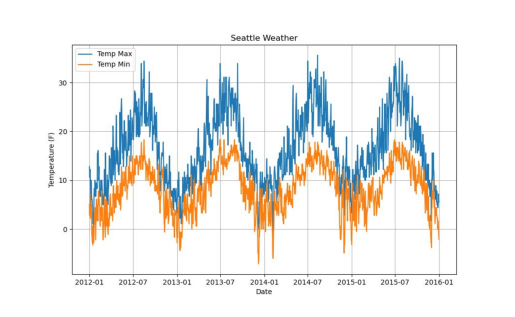

Commander (to Critics):

Improve <image>

--------------------------------------------------------------------------------
Critics (to Commander):

To improve the provided figure of Seattle Weather, here are a few suggestions:

1. Data Overlap: There is a significant overlap between the Temp Max (in blue) and Temp Min (in orange) data series, which can make it difficult to follow individual series, especially in cases where Min and Max temperatures are close. This can be improved by either using a line plot with less opacity, applying smoothing to the data lines, or by representing one of the data series in a different manner, such as with a filled area chart underneath the line plot.

2. Labeling: While the axes are labeled, it may be useful to provide units of measurement on the Y-axis label, to clarify that the temperatures are in Fahrenheit. Additionally, including a more descriptive title can help provide context.

3. Grid Lines: The grid lines are helpful for reading the plot, bu

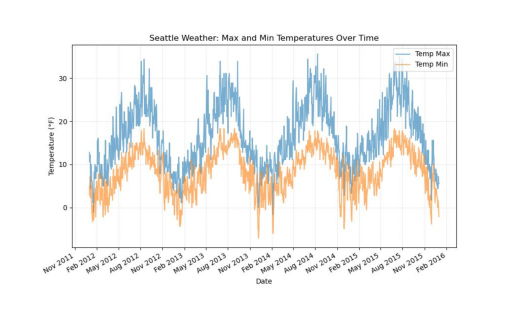

Commander (to Critics):

Improve <image>

--------------------------------------------------------------------------------
Commander (to Coder):

Here is the feedback to your figure. Please improve! Save the result to `result.jpg`
Improve <img result.jpg>

--------------------------------------------------------------------------------
Coder (to Commander):

I would appreciate more specific feedback on the figure, however, assuming the context, we could improve the figures as follows:

1. Increase line width for better visibility.
2. Separate out data into two subplots - one for each temperature series to avoid data overlap.
3. Utilize a dark theme for a more modern look.
4. Implement more interactive elements, like hover tooltips (would require shifting from matplotlib to an interactive library like bokeh or plotly).

Please note, that adding interactive elements to a .jpg file is not possible. 

Here is the Python code block reflecting first three improvements:

Python:
```python
imp

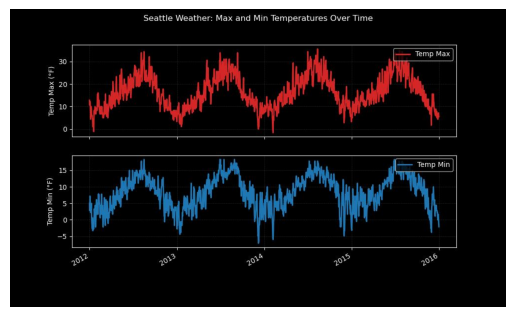

Figure Creator~ (to User):

result.jpg

--------------------------------------------------------------------------------


In [6]:
import matplotlib.pyplot as plt
import time
from PIL import Image


# config_list_gpt35 = autogen.config_list_from_json(
#     "OAI_CONFIG_LIST",
#     filter_dict={
#         "model": ["gpt-35-turbo", "gpt-3.5-turbo"],
#     },
# )

# gpt35_llm_config = {"config_list": config_list_gpt35, "cache_seed": 42}


creator = FigureCreator(
    name="Figure Creator~",
    llm_config=gpt4_llm_config
    
)

user_proxy = autogen.UserProxyAgent(
    name="User",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=0
)

user_proxy.initiate_chat(creator, message="""
Plot a figure by using the data from:
https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv

I want to show both temperature high and low.
""")


In [7]:
if os.path.exists("result.jpg"):
    os.remove("result.jpg") # clean up

## Group Chat Example with Multimodal Agent

In [8]:
agent1 = MultimodalConversableAgent(
    name="image-explainer-1",
    max_consecutive_auto_reply=10,
    llm_config={"config_list": config_list_4v, "temperature": 0.5, "max_tokens": 300},
    system_message="Your image description is poetic and engaging.",
)
agent2 = MultimodalConversableAgent(
    name="image-explainer-2",
    max_consecutive_auto_reply=10,
    llm_config={"config_list": config_list_4v, "temperature": 0.5, "max_tokens": 300},
    system_message="Your image description is factual and to the point.",
)

user_proxy = autogen.UserProxyAgent(
    name="User_proxy",
    system_message="Ask both image explainer 1 and 2 for their description.",
    human_input_mode="TERMINATE",  # Try between ALWAYS, NEVER, and TERMINATE
    max_consecutive_auto_reply=10,
)

# We set max_round to 5
groupchat = autogen.GroupChat(agents=[agent1, agent2, user_proxy], 
                              messages=[], 
                              max_round=5)
group_chat_manager = autogen.GroupChatManager(groupchat=groupchat, 
                                              llm_config=gpt4_llm_config)

user_proxy.initiate_chat(group_chat_manager,
                        message=f"""Describe the image:
                        <img https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0>.""")

User_proxy (to chat_manager):

Describe the image:
                        <img https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0>.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
image-explainer-1 (to chat_manager):

In a soft-focus world, a caramel-colored puppy with a coat of curly fur sits serenely, its innocent eyes gazing into the distance. Adorned with a collar that hosts a vibrant, multicolored bandana and a shiny tag engraved with the name "Webster," the pup exudes a sense of youthful curiosity and gentle charm. Behind this bundle of joy, the muted backdrop of a home's interior whispers tales of comfort and domesticity, with a pair of black boots resting by the door, hinting at the comings and goings of human life amidst which this little creature finds its love and belonging.

--------------------------------------------------------------------------------

>>>>>>>> 